In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [37]:
df = pd.read_csv("../data/raw/MachineLearningRating_v3.txt", sep="|", low_memory=False)

df.head()


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [38]:
df.shape

(1000098, 52)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

In [40]:
# Column 32 - NewVehicle
print(df['NewVehicle'].unique()[:20])

# Column 37 - CrossBorder
print(df['CrossBorder'].unique())


['More than 6 months' nan 'Less than 6 months']
[nan 'No']


Fix Columns

NewVehicle

In [41]:
# Fill missing values with 'Unknown' and convert to category
df['NewVehicle'] = df['NewVehicle'].fillna('Unknown').astype('category')

# Optional: create numeric version for modeling
df['NewVehicleMonths'] = df['NewVehicle'].map({
    'Less than 6 months': 3,
    'More than 6 months': 12,
    'Unknown': np.nan
})


Crossborder


In [42]:
df['CrossBorder'] = df['CrossBorder'].fillna('No').astype('category')


In [ ]:
#Checking how it is displayed after fixing
print(df['NewVehicle'].unique()[:20])

# Column 37 - CrossBorder
print(df['CrossBorder'].unique())


['More than 6 months', 'Unknown', 'Less than 6 months']
Categories (3, object): ['Less than 6 months', 'More than 6 months', 'Unknown']
['No']
Categories (1, object): ['No']


Convert Numeric Columns Properly

In [44]:
numeric_cols = ['TotalPremium', 'TotalClaims', 'CustomValueEstimate', 
                'Cylinders', 'cubiccapacity', 'kilowatts', 
                'NumberOfDoors', 'NumberOfVehiclesInFleet']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [45]:
# Remove invalid numeric values
df = df[(df['TotalPremium'] >= 0) & (df['TotalClaims'] >= 0)]

# Fill categorical missing
for col in ['Bank', 'AccountType', 'Gender', 'MaritalStatus']:
    df[col] = df[col].fillna('Unknown')

# Fill flags
for col in ['Rebuilt', 'Converted', 'WrittenOff', 'CrossBorder']:
    df[col] = df[col].fillna('No')

# Fill numeric missing
for col in ['Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors']:
    df[col] = df[col].fillna(df[col].median())

# Convert date columns
df['VehicleIntroDate'] = pd.to_datetime(df['VehicleIntroDate'], errors='coerce')
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')


C:\Users\THINKPAD\AppData\Local\Temp\ipykernel_6868\2449214591.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['VehicleIntroDate'] = pd.to_datetime(df['VehicleIntroDate'], errors='coerce')


Feature Engineering – Loss Ratio

In [46]:
# Only for rows with positive premium
df = df[df['TotalPremium'] > 0]

df['LossRatio'] = df['TotalClaims'] / df['TotalPremium']

# Check
df['LossRatio'].describe()


count    618174.000000
mean          0.350095
std           9.288613
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2553.600000
Name: LossRatio, dtype: float64

Exploratory Data Analysis (EDA)

Univariate Analysis

Numerical Features 

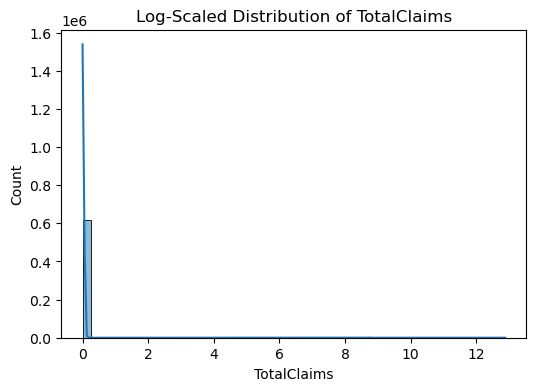

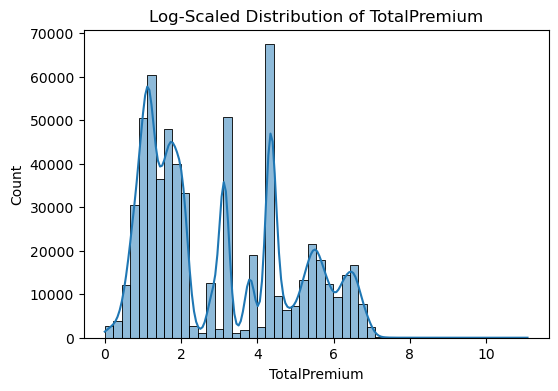

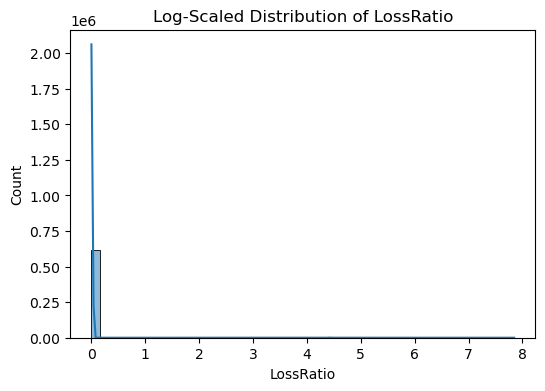

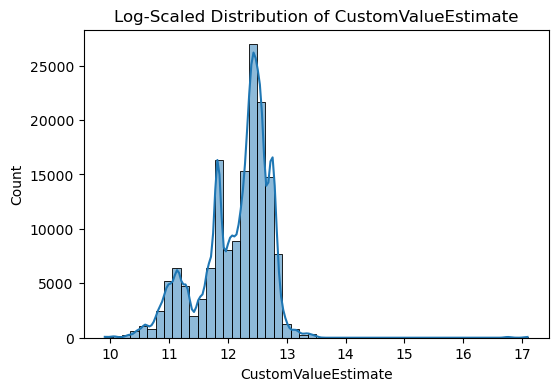

In [47]:
numeric_cols_eda = ['TotalClaims', 'TotalPremium', 'LossRatio', 'CustomValueEstimate']

for col in numeric_cols_eda:
    plt.figure(figsize=(6,4))
    sns.histplot(np.log1p(df[col]), bins=50, kde=True)
    plt.title(f'Log-Scaled Distribution of {col}')
    plt.show()


Categorical Features

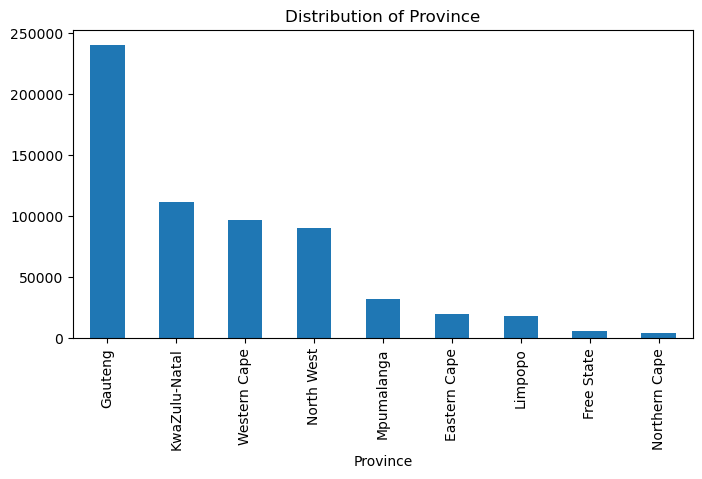

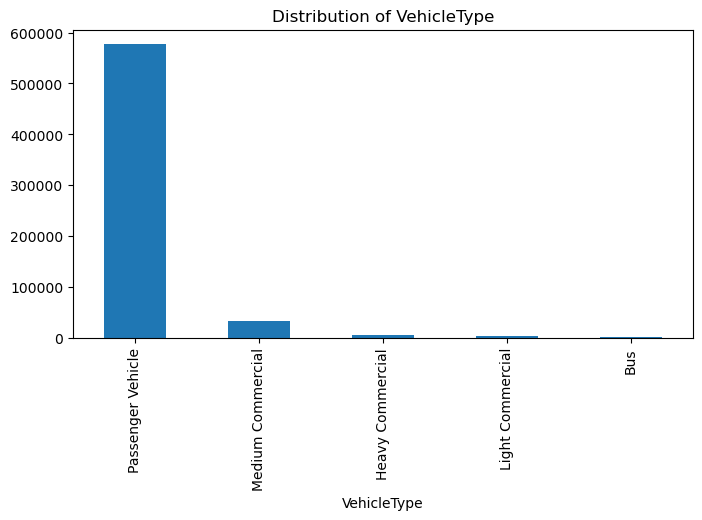

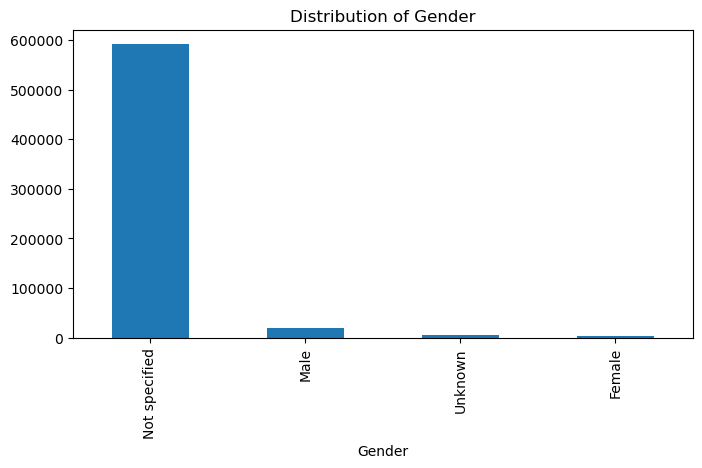

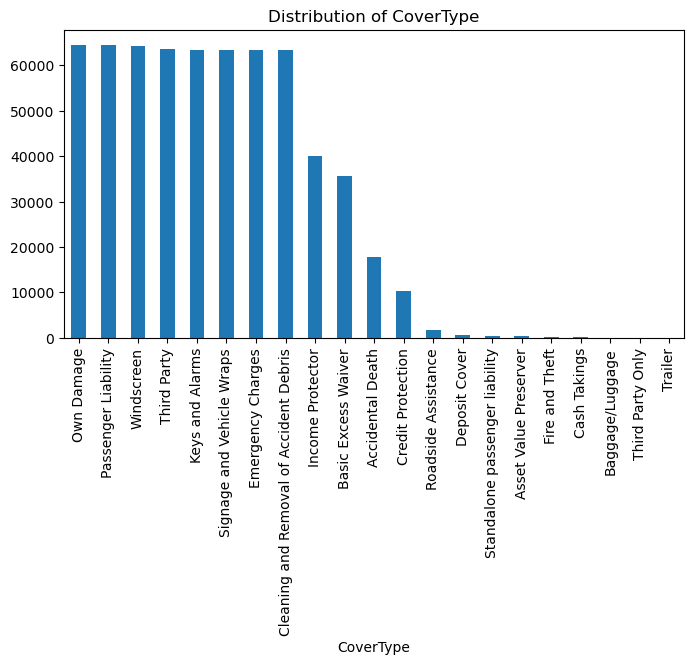

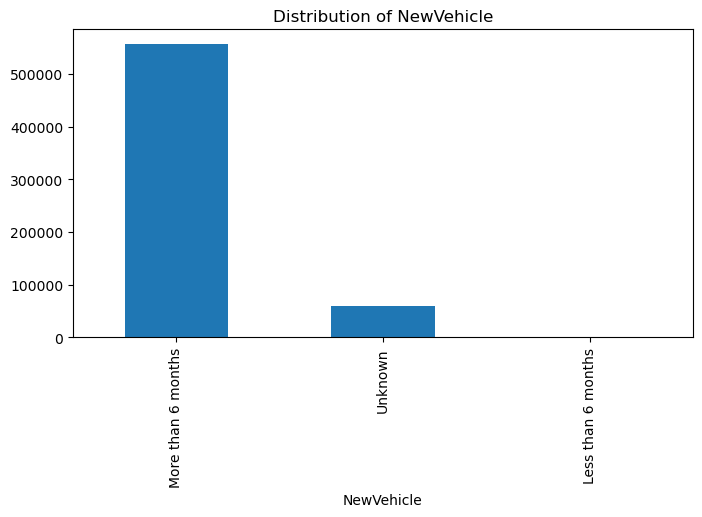

In [48]:
cat_cols = ['Province', 'VehicleType', 'Gender', 'CoverType', 'NewVehicle']

for col in cat_cols:
    plt.figure(figsize=(8,4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.show()


Bivariate / Multivariate Analysis

Loss Ratio by Category

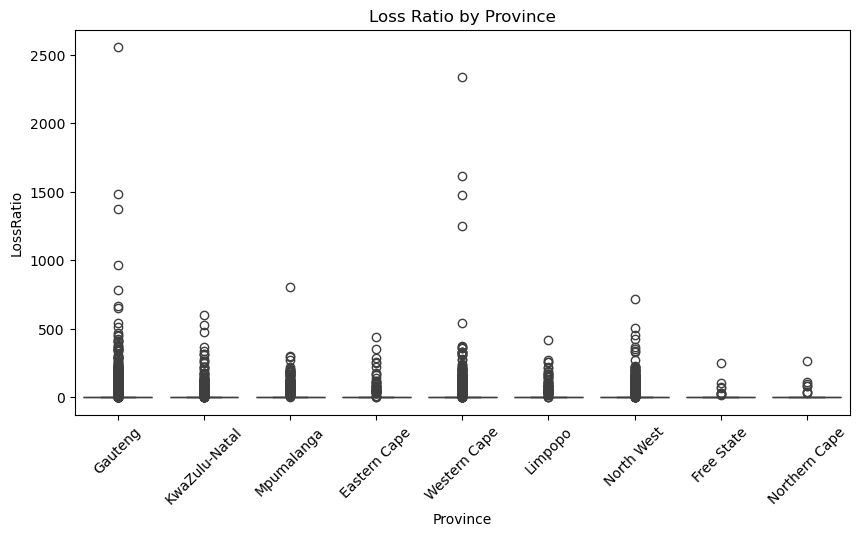

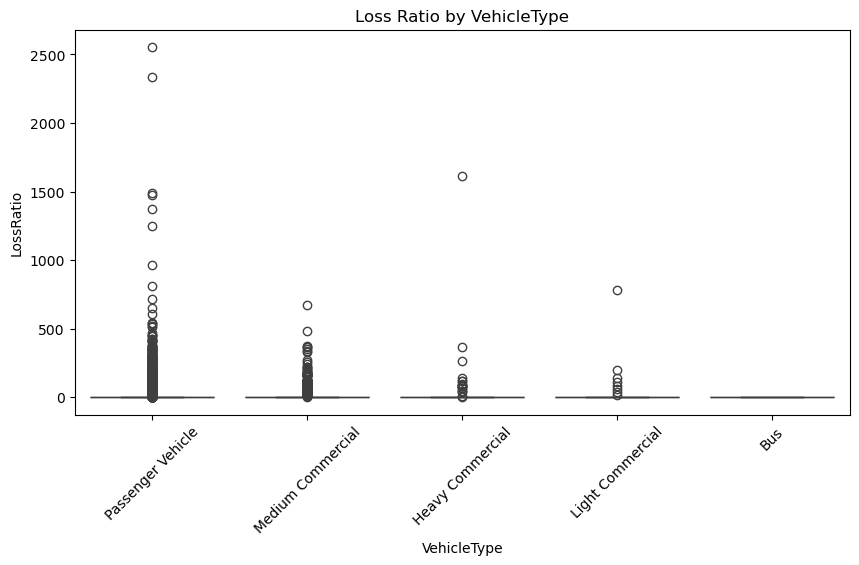

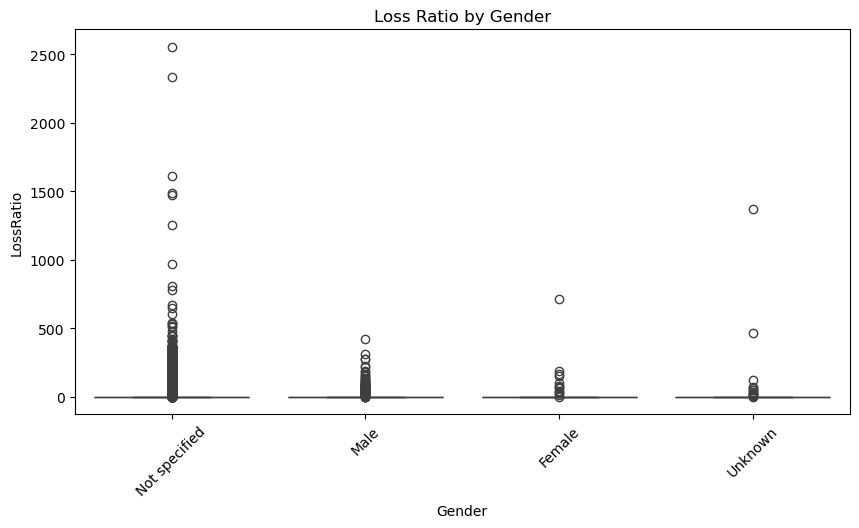

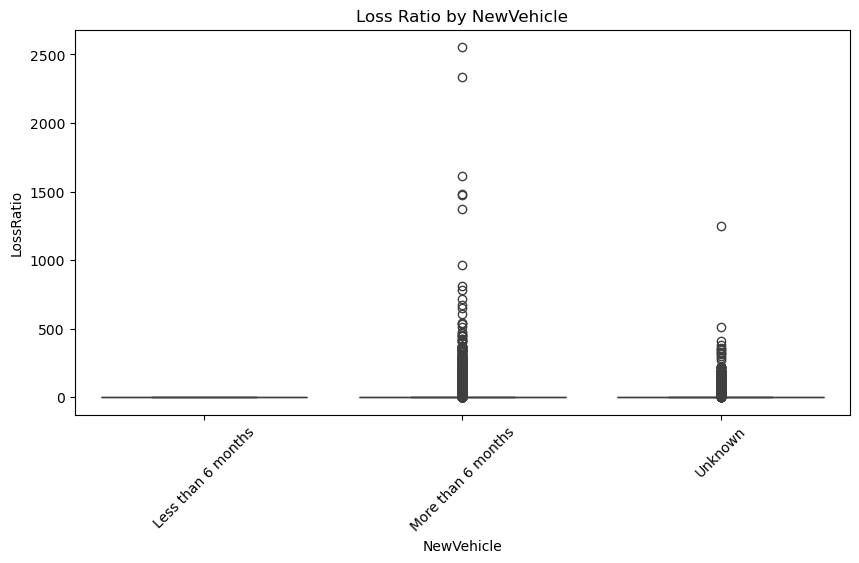

In [49]:
for col in ['Province', 'VehicleType', 'Gender', 'NewVehicle']:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=col, y='LossRatio', data=df)
    plt.title(f'Loss Ratio by {col}')
    plt.xticks(rotation=45)
    plt.show()


Correlation Matrix

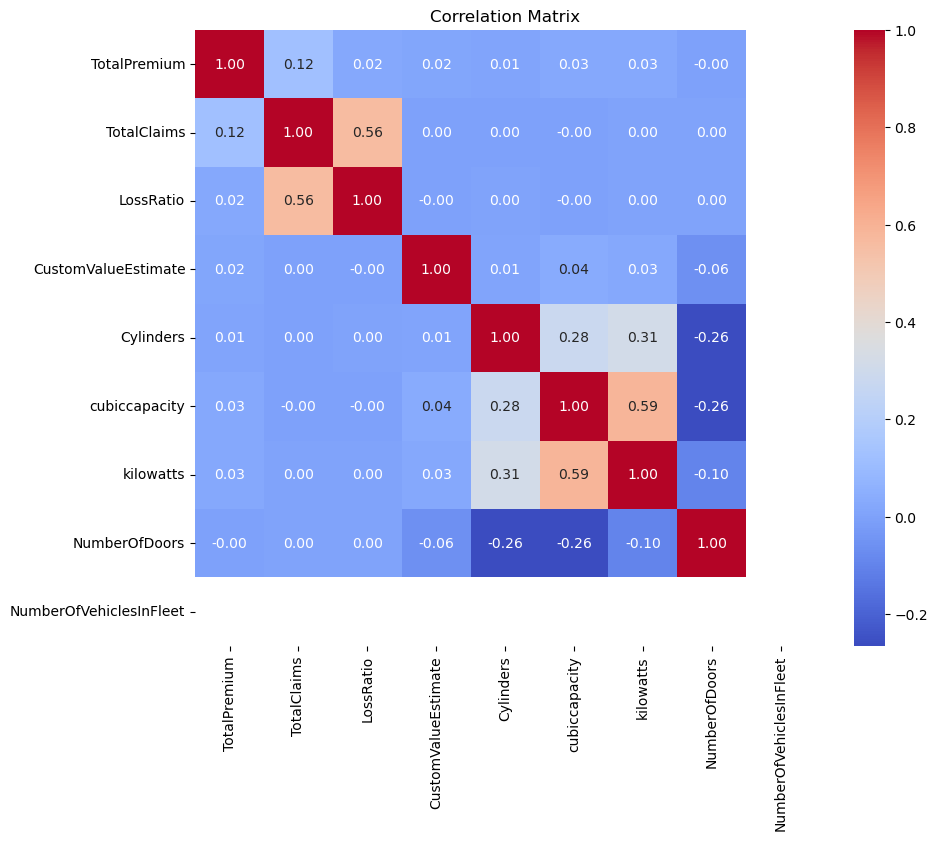

In [50]:
numeric_cols_corr = ['TotalPremium','TotalClaims','LossRatio','CustomValueEstimate',
                     'Cylinders','cubiccapacity','kilowatts','NumberOfDoors','NumberOfVehiclesInFleet']

plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols_corr].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()


Temporal Trends

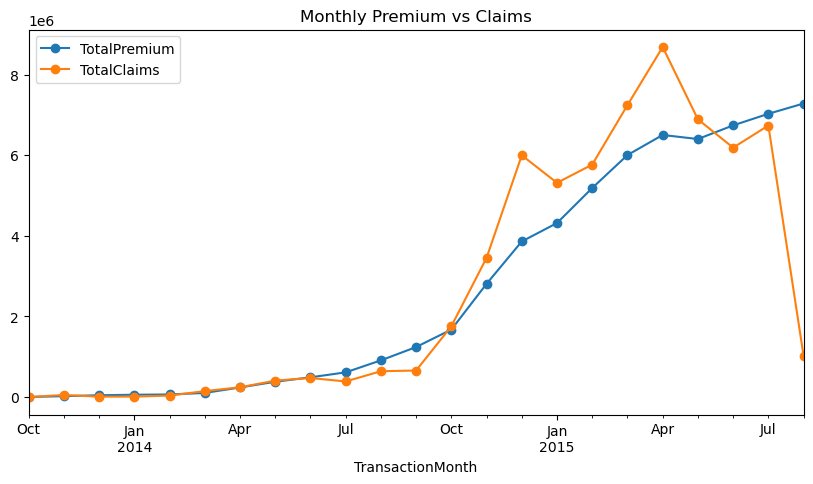

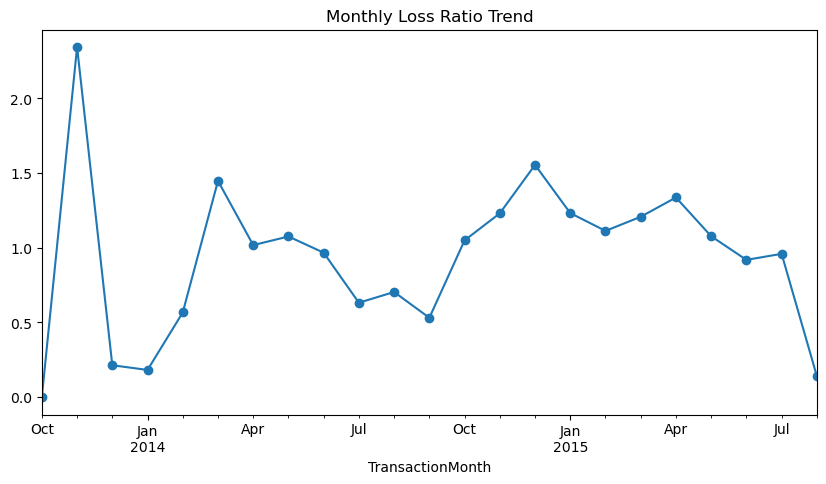

In [51]:
monthly = df.groupby(df['TransactionMonth'].dt.to_period('M'))[['TotalPremium','TotalClaims']].sum()
monthly['LossRatio'] = monthly['TotalClaims'] / monthly['TotalPremium']

monthly[['TotalPremium','TotalClaims']].plot(marker='o', figsize=(10,5))
plt.title('Monthly Premium vs Claims')
plt.show()

monthly['LossRatio'].plot(marker='o', figsize=(10,5))
plt.title('Monthly Loss Ratio Trend')
plt.show()


Outlier Detection

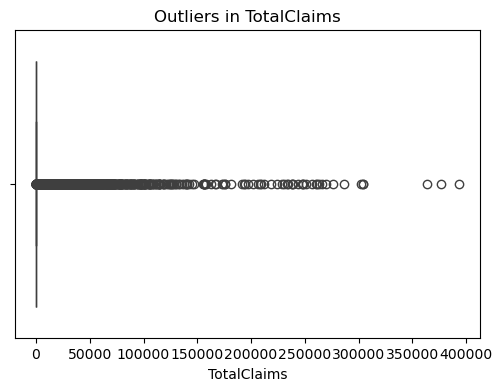

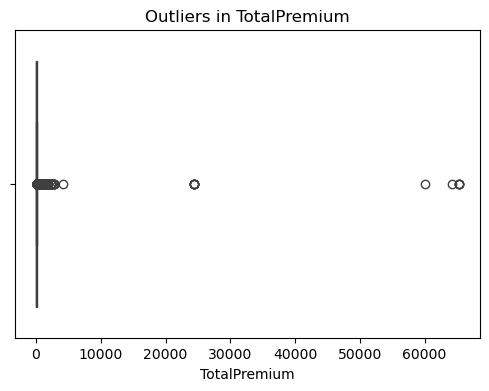

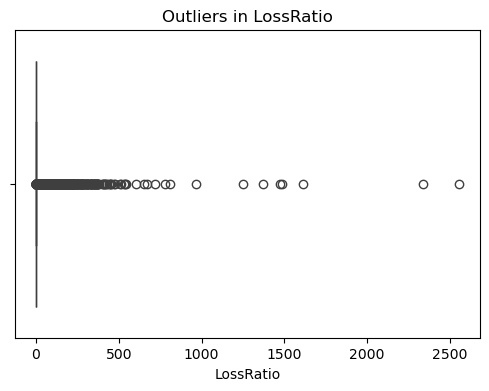

In [52]:
for col in ['TotalClaims', 'TotalPremium', 'LossRatio']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f'Outliers in {col}')
    plt.show()


In [54]:
df.shape

(618174, 54)

In [58]:
df.to_csv("../data/processed/cleaned_dataset.csv", index=False)
